# 实验7. 支持向量机及文本分类

## 实验目的

1、学会使用sklearn库中的支持向量机的相关函数

2、使用软间隔SVM（C-SVM）体验代价函数中经验误差和松弛因子的作用

3、使用带有高斯核函数的SVM对非线性数据进行分类，体验高斯核函数的作用

4、使用交叉验证（Cross Validation）和参数网格（Grid Search）对模型参数进行调参

5、通过垃圾邮件检测，体验文本特征化和文本分类。

## 实验数据
ex6data1.mat - 二类线性可分数据集（带有一个异常点）

ex6data2.mat - 非线性二类可分数据集

ex6data3.mat - 用于调参的二分类数据集

spamTrain.mat - 用于垃圾邮件分类的训练数据集

spamTest.mat - 用于垃圾邮件分类的测试数据集

emailSample1.txt、emailSample2.txt - 用于测试的正常邮件

spamSample1.txt、spamSample2.txt - 用于测试的垃圾邮件

vocab.txt - 邮件中出现的单词列表

## 1. 使用sklearn中的支持向量机

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import svm 

'''读取数据集'''

data1 = loadmat('ex6data1.mat')
data2 = loadmat('ex6data2.mat')
data3 = loadmat('ex6data3.mat')
X1 = data1['X']
y1 = data1['y'].flatten()
X2 = data2['X']
y2 = data2['y'].flatten()
X3 = data3['X']
y3 = data3['y'].flatten()
Xval = data3['Xval']
yval = data3['yval'].flatten()

### 1.1 调用sklearn.svm.SVC对示例代码进行二分类

In [85]:
'''可视化数据集'''
def plot_data(x, y):
    pos = x[y == 1]
    neg = x[y == 0]
    plt.scatter(pos[:,0], pos[:,1], c='k', marker='+')
    plt.scatter(neg[:,0], neg[:,1], c='y', marker='o', edgecolors='k', linewidths=0.5)
    plt.show

'''画出决策边界'''
def plot_boundary(clf, x1, desc=''):
    u_span = np.max(x1[:,0]) - np.min(x1[:,0])
    v_span = np.max(x1[:,1]) - np.min(x1[:,1])
    u = np.linspace(np.min(x1[:,0])-u_span/10 , np.max(x1[:,0])+ u_span/10, 500) #为了后面可以直接调用这个函数
    v = np.linspace(np.min(x1[:,1])-v_span/10 , np.max(x1[:,1])+ v_span/10, 500)
    x1, x2 = np.meshgrid(u, v) #转为网格（500*500）
    y = clf.predict(np.c_[x1.flatten(), x2.flatten()]) #因为predict中是要输入一个二维的数据，因此需要展开
    y = y.reshape(x1.shape) #重新转为网格
    plt.contour(x1, x2, y, 1, colors='b') #画等高线
    plt.title('The Decision Boundary'+desc)
    plt.show

构造示例训练数据X，y，使用该数据调用sklearn.svm.SVC()来训练支持向量机

[0]


<function matplotlib.pyplot.show(close=None, block=None)>

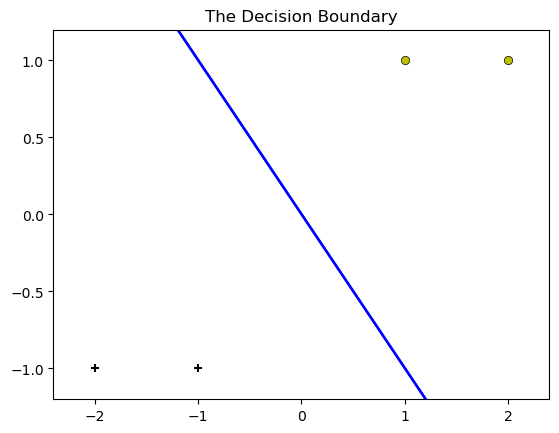

In [86]:
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([1, 1, 0, 0])

# 画样本
plot_data(X, y)
clf = svm.SVC(C=1, kernel='linear')
clf.fit(X, y)
print(clf.predict([[1.5, 0.75]]))

# 绘制分类超平面
plot_boundary(clf, X)
plt.show

### 1.2 体验软间隔SVM代价函数中经验误差和松弛因子的作用

In [87]:
from scipy.io import loadmat
data1 = loadmat('ex6data1.mat')
X1 = data1['X']
y1 = data1['y'].flatten()

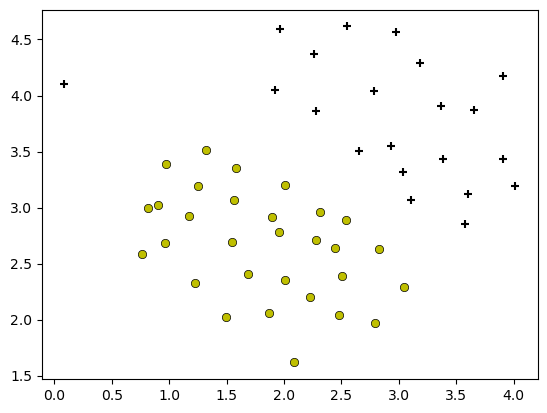

In [88]:
# 调用plot_data()可视化ex7data1.mat
plot_data(X1, y1)

#### 1.2.1 C = 1（经验风险和间隔比较均衡）

array([1], dtype=uint8)

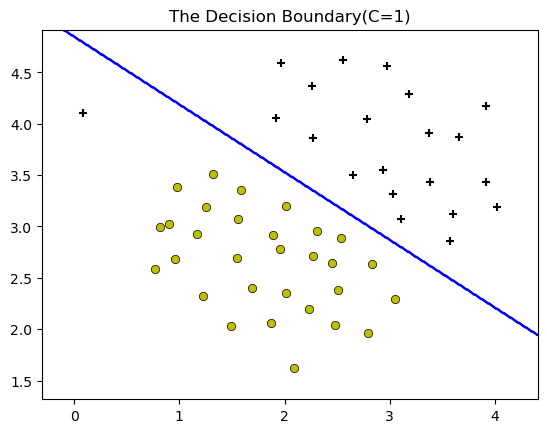

In [89]:
'''线性核函数模型-样本1'''
linearSVMC1 = svm.SVC(C=1, kernel='linear')
linearSVMC1.fit(X1, y1) #此处类别标签 y1 最好用一维数组（1d array）来存储
#画图   
plot_data(X1, y1)
plot_boundary(linearSVMC1, X1, '(C=1)')
plt.show
linearSVMC1.predict([[2, 4.5]])

#### 1.2.2 C = 100 (经验风险最重要)

<function matplotlib.pyplot.show(close=None, block=None)>

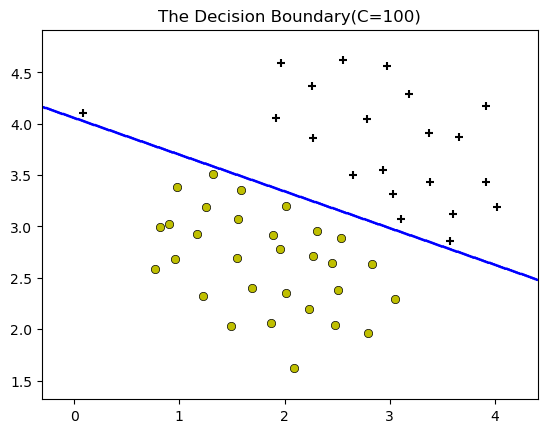

In [90]:
linearSVMC100 = svm.SVC(C=100, kernel='linear')
linearSVMC100.fit(X1, y1)

plot_data(X1, y1)
plot_boundary(linearSVMC100, X1, '(C=100)')
plt.show

#### 1.2.2 C = 0 （只考虑最大间隔）

<function matplotlib.pyplot.show(close=None, block=None)>

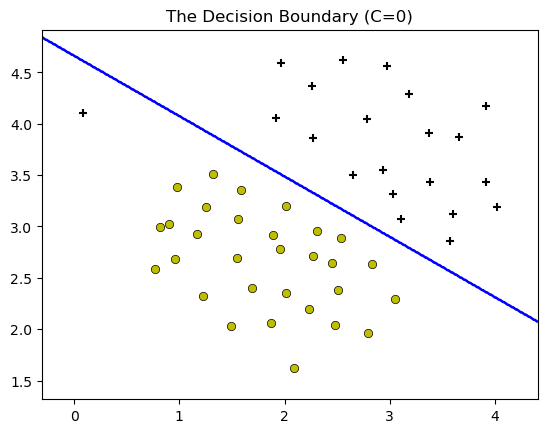

In [91]:
linearSVMC0 = svm.LinearSVC() # SVC要求的C必须大于0
linearSVMC0.fit(X1, y1)

plot_data(X1, y1)
plot_boundary(linearSVMC0, X1, ' (C=0)')
plt.show

### 1.3 使用SVM和高斯核函数解决非线性可分问题

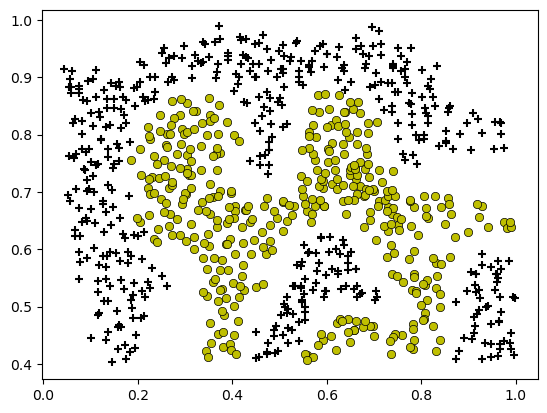

In [92]:
#可视化ex7_data2.mat
plot_data(X2, y2) 

### 1.3.1 实现高斯核函数

In [93]:
# 定义高斯核函数
# 运算符 @ 是矩阵乘
def gaussianKernel(x1, x2, sigma):
    return np.exp(- np.sum((x1 - x2)**2) / 2 / sigma**2)
    
a1 = np.array([1, 2, 1])
a2 = np.array([0, 4, -1])
sigma = 2
gaussianKernel(a1, a2, sigma) #检查是否为0.32465246735834974

0.32465246735834974

### 1.3.2 使用带有高斯核函数的SVM

<function matplotlib.pyplot.show(close=None, block=None)>

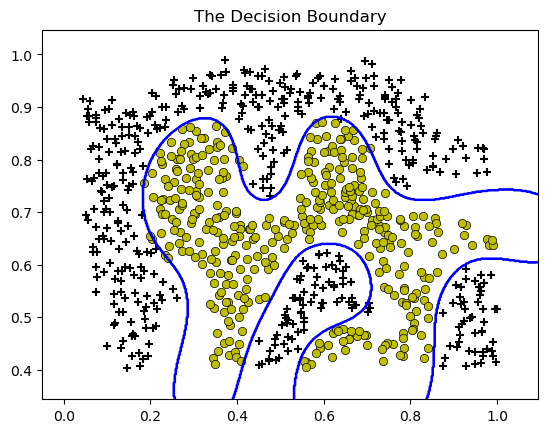

In [94]:
#训练模型（这里使用内置高斯核，RBF是径向基函数，高斯核是它的一种）
sigma = 0.1
clf2 = svm.SVC(C = 1, kernel = 'rbf', gamma = 1 / ( 2 * sigma * sigma)) #对应sigma=0.1
clf2.fit(X2, y2)
#clf2.predict([[0.4, 0.9]])

#画图   
plt.figure(2)
plot_data(X2, y2)
plot_boundary(clf2, X2)
plt.show

### 1.4 使用交叉验证和参数网格对超参数进行调整
#### 1.4.1 可视化训练数据集和验证数据集

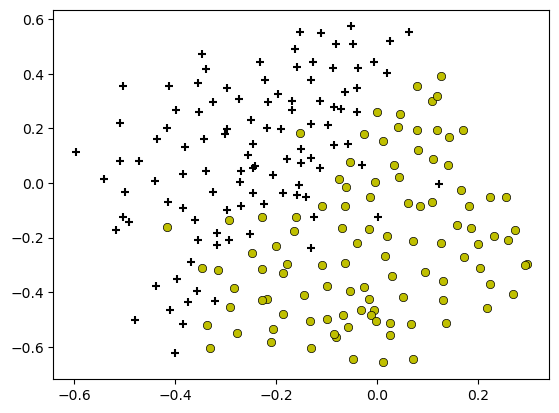

In [95]:
'''============================part3========================='''
'''高斯核函数模型-样本3'''
# 可视化训练集
plot_data(X3, y3) 

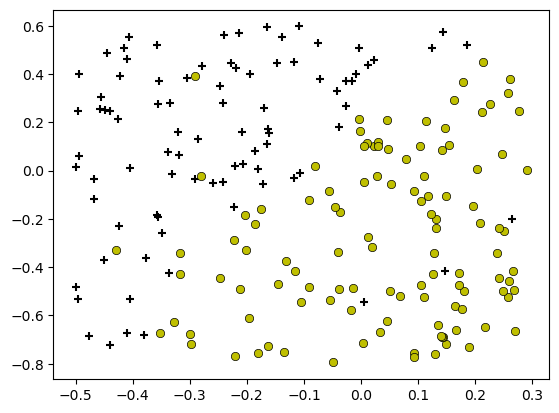

In [96]:
# 可视化验证集
plot_data(Xval, yval) 

#### 1.4.2 调参（hyper-parameter tuning）

In [97]:
try_value = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])
#错误率
def error_rate(predict_y, yval):
    m = yval.size
    count = 0
    for i in range(m):
        count = count + np.abs(int(predict_y[i])-int(yval[i])) #避免溢出错误得到225
    return float(count/m)    

#模型选择
def model_selection(try_value, x3, y3, xval, yval):
    error = 1
    c = 1
    sigma = 0.01
    for i in range(len(try_value)):
        for j in range(len(try_value)):
            clf = svm.SVC(C=try_value[i], kernel='rbf', gamma=np.power(try_value[j], -2)/2)
            clf.fit(x3, y3)
            predict_y = clf.predict(xval) 
            if error > error_rate(predict_y, yval):
                error = error_rate(predict_y, yval)
                c = try_value[i]
                sigma = try_value[j]
    return c, sigma, error

c, sigma, error = model_selection(try_value, X3, y3, Xval, yval) #(1.0, 0.1, 0.035)  
print(c, sigma, error)

1.0 0.1 0.035


#### 1.4.3 可视化最优参数下的SVM在ex7data3上的表现
首先绘制训练数据集和训练得到的SVM

<function matplotlib.pyplot.show(close=None, block=None)>

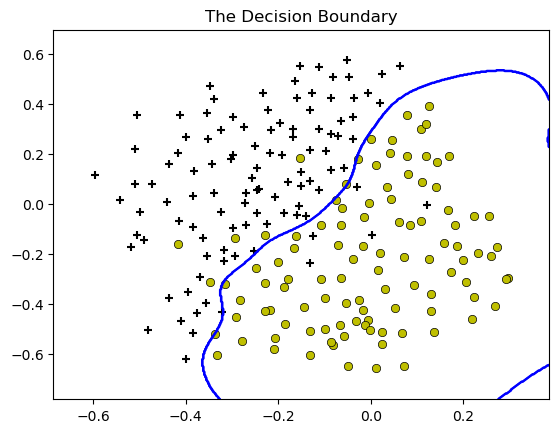

In [98]:
clf3 = svm.SVC(C=c, kernel='rbf', gamma=np.power(sigma, -2)/2)
clf3.fit(X3, y3)

#画图   
plot_data(X3, y3)
plot_boundary(clf3, X3)
plt.show

然后，绘制验证数据集和SVM

<function matplotlib.pyplot.show(close=None, block=None)>

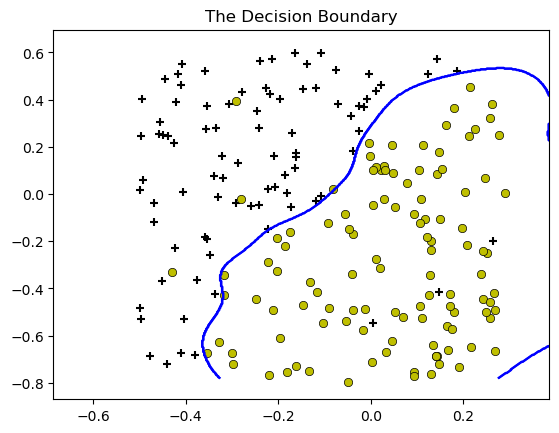

In [99]:
plot_data(Xval, yval)
plot_boundary(clf3, X3)
plt.show

## 2. 使用SVM进行文本分类（垃圾邮件检测）

In [100]:
import re # 正则表达式
from nltk.stem import PorterStemmer # 自然语言处理中的英文单词词干提取

### 2.1 对邮件数据进行预处理和向量化

In [101]:
# 1.邮件预处理
def readEmail(emailFile):
    f = open(emailFile,'r',encoding='utf-8')
    email = f.read()
    f.close()
    return email

emailSample1 = readEmail('./emailSample1.txt')
print(emailSample1)
print('===============================================')
emailSample2 = readEmail('./emailSample2.txt')
print(emailSample2)
print('===============================================')
spamSample1 = readEmail('./spamSample1.txt')
print(spamSample1)
print('===============================================')
spamSample2 = readEmail('./spamSample2.txt')
print(spamSample2)

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com


Folks,
 
my first time posting - have a bit of Unix experience, but am new to Linux.

 
Just got a new PC at home - Dell box with Windows XP. Added a second hard disk
for Linux. Partitioned the disk and have installed Suse 7.2 from CD, which went
fine except it didn't pick up my monitor.
 
I have a Dell branded E151FPp 15" LCD flat panel monitor and a nVidia GeForce4
Ti4200 video card, both of which are probably too new to feature in Suse's default
set. I downloaded a driver from the nVidia website and installed it using RPM.
Then I ran Sax2 (as was recommended in some postings I found on the net), 

In [102]:
def preprocess(email):
    """做除了Word Stemming和Removal of non-words的所有处理"""
    # 大写转小写
    email = email.lower()
    # 移除html标签
    email = re.sub(r'<.*>','',email)
    # 移除url
    email = re.sub(r'(http|https)://[^\s]*','httpaddr',email)
    # 移除＄，解决dollar 和 number 的连接问题
    email = re.sub(r'[\$][0-9]+','dollar number',email)
    # 移除单个$
    email = re.sub(r'\$','dollar number',email)
    # 移除数字
    email = re.sub(r'[0-9]+', 'number', email)
    # 移除邮箱
    email = re.sub(r'[^\s]+@[^\s]+','emailaddr',email)
    return email


def preprocess2(email):
    """预处理数据 : 提取词干，去除非字符内容"""

    stemmer = PorterStemmer()
    email = preprocess(email)

    # 将邮件分割为单个单词，re.split()可以设置多种分隔符
    tokens = re.split('[ \@\$\/\#\.\-\:\&\*\+\=\[\]\?\!\(\)\{\}\,\'\"\>\_\<\;\%]', email)

    # 遍历每个分割出来的内容
    tokenlist = []
    for token in tokens:
        #删除任何非字母的字符
        token = re.sub('[^a-zA-Z0-9]','',token)
        #提取词根
        stemmed = stemmer.stem(token)
        # 去除空字符串“:里面不包含任何字符
        if not len(token):continue
        tokenlist.append(stemmed)

    return tokenlist

### 2.2 邮件的特征向量构建

In [103]:
import pandas as pd
def VocabIndex(email):
    # 1. 对当前邮件进行预处理
    """提取存在单词的索引"""
    tokenlist = preprocess2(email)
    vocab_list = {}
    with open('vocab.txt', 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            vocab_list[parts[1]] = parts[0]
    index = tuple(vocab_list.get(key) for key in tokenlist)
    temp_list = list(index)
    index = [item for item in temp_list if item is not None]
    return tuple(index)

print(VocabIndex(emailSample1))
print(VocabIndex(emailSample2))
print(VocabIndex(spamSample1))
print(VocabIndex(spamSample2))

('86', '916', '794', '1077', '883', '370', '1699', '790', '1822', '1831', '883', '431', '1171', '794', '1002', '1893', '1364', '592', '1676', '238', '162', '89', '688', '945', '1663', '1120', '1062', '1699', '375', '1162', '477', '1120', '1893', '1510', '799', '1182', '1237', '810', '1895', '1440', '1547', '181', '1699', '1758', '1896', '688', '1676', '992', '961', '1477', '71', '530', '1699', '531')
('662', '1084', '652', '1694', '1280', '756', '186', '1162', '1752', '594', '225', '64', '1099', '1699', '960', '902', '726', '1099', '1228', '124', '787', '427', '208', '1860', '1855', '1885', '21', '1464', '752', '960', '1217', '1666', '464', '74', '756', '847', '1627', '1120', '1120', '688', '259', '1840', '583', '883', '450', '1249', '1760', '1084', '1061', '756', '427', '210', '1120', '1208', '1061', '74', '1792', '246', '204', '1162', '1840', '1308', '1708', '1099', '1699', '626', '825', '1627', '487', '492', '688', '1666', '1824', '74', '847', '883', '1437', '1671', '116', '1803', '

In [104]:
def VectoringEmail(email):
    df = pd.read_table('./vocab.txt', names=['words'])
    vector = np.zeros(1899)
    index = VocabIndex(email)
    for i in index:
        vector[int(i)] = 1
    return vector

vector = VectoringEmail(emailSample1)
print(vector)
print('length of vector = {}\nnum of non-zero = {}'.format(len(vector), int(vector.sum())))
vector = VectoringEmail(emailSample2)
print(vector)
print('length of vector = {}\nnum of non-zero = {}'.format(len(vector), int(vector.sum())))
vector = VectoringEmail(spamSample1)
print(vector)
print('length of vector = {}\nnum of non-zero = {}'.format(len(vector), int(vector.sum())))
vector = VectoringEmail(spamSample2)
print(vector)
print('length of vector = {}\nnum of non-zero = {}'.format(len(vector), int(vector.sum())))


[0. 0. 0. ... 1. 0. 0.]
length of vector = 1899
num of non-zero = 45
[0. 0. 0. ... 0. 0. 0.]
length of vector = 1899
num of non-zero = 120
[0. 0. 0. ... 1. 0. 0.]
length of vector = 1899
num of non-zero = 48
[0. 0. 0. ... 0. 0. 0.]
length of vector = 1899
num of non-zero = 18


### 2.3 使用支持向量机对邮件进行分类，进而进行垃圾邮件检测

In [105]:
from scipy.io import loadmat
# Training set
mat1 = loadmat('./spamTrain.mat')
X, y = mat1['X'], mat1['y']

clf = svm.SVC(C=0.1, kernel='linear')
clf.fit(X, y)

d:\software\anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.1, kernel='linear')

使用训练好的文本分类SVM对spamTest.mat进行分类

In [106]:
# 装载测试数据集，用于性能评估
spamTest = loadmat('./spamTest.mat')
Xtest, ytest = spamTest['Xtest'], spamTest['ytest']
# 预测
perfTrain = clf.score(X, y)
perfTest = clf.score(Xtest, ytest)
print('在训练数据集上的准确率：', perfTrain)
print('在测试数据集上的准确率：' , perfTest)

在训练数据集上的准确率： 0.99825
在测试数据集上的准确率： 0.989
